In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

import pandas as pd
import numpy as np
import gc
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

# classifiers  
from sklearn.linear_model import LogisticRegression

# sampling 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline


from utils.data_extract_utils import remove_highly_correlated_columns, get_home_credit_data, extract_zip, extract_features_from_bureau, EXTRACTRED_BUREAU_COLUMNS, extract_features_from_installments_payments

In [2]:
# Download, and extract data from dropbox into memory. 
data = get_home_credit_data()

In [3]:
def get_temp_data(data):
    ## combine train and test set
    train_test = data['application_train'].copy().append(data['application_test']).reset_index()

    # join tables: bureau, bureau_balance - 1 min to execute
    bb = extract_features_from_bureau(data['bureau'], data['bureau_balance'])
    ip = extract_features_from_installments_payments(data['installments_payments'])

    # Join Bureau(s) and Application tables
    train_test.set_index('SK_ID_CURR', inplace=True, drop=False)
    df = pd.concat([train_test, bb, ip], axis=1)

    # drop index column generated by groupby
    #df.drop(['index'], axis=1, inplace=True)
    
    # clean memory 
    del bb
    gc.collect()
    
    # preprocess 
    ## DAYS_EMPLOYED
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: abs(x))

    df['BIRTH_IN_YEARS'] = df['DAYS_BIRTH'].apply(lambda x: abs(x)/365)

    # remove 4 instances
    df = df.loc[df['CODE_GENDER'] != 'XNA', :]

    # add new features 
    df['ALL_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    df['PAYMENT_RATE'] = df['AMT_ANNUITY']/df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL']/df['CNT_FAM_MEMBERS']
    df['INCOME_CREDIT_IN_PERCENTAGE '] = df['AMT_INCOME_TOTAL']/df['AMT_CREDIT']
    df['ANNUITY_INCOME_IN_PERCENTAGE'] = df['AMT_ANNUITY']/df['AMT_INCOME_TOTAL']

    ## label encoder for binary values
    bin_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

    replace_dict = {'CODE_GENDER': {'M': 0, 'F': 1},
                    'FLAG_OWN_CAR': {'Y': 0, 'N': 1}, 
                    'FLAG_OWN_REALTY':{'Y': 0, 'N': 1} }
    df.replace(replace_dict, inplace=True)

    # test ids
    test_ids = df.loc[df['TARGET'].isnull(), 'SK_ID_CURR']
    
    # drop ids
    df.drop(columns=['SK_ID_CURR'], axis=1, inplace=True)
    
    return df, test_ids

In [141]:
df, test_ids = get_temp_data(data)

In [155]:
sub_df = df
display(df)
display(df.info())

,index,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_CREDIT_DEBT_RATIO,CREDIT_DAY_OVERDUE,DPD_COUNTS,MIS_INSTALMENT_PAYMENTS,BIRTH_IN_YEARS,ALL_EXT_SOURCE_MEAN,PAYMENT_RATE,INCOME_PER_PERSON,INCOME_CREDIT_IN_PERCENTAGE,ANNUITY_INCOME_IN_PERCENTAGE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,0,NaN,Cash loans,1,1,0,0,135000.0,568800.0,20560.5,...,0.282518,0.0,0.142857,0.00000,52.715068,0.567263,0.036147,67500.0,0.237342,0.152300
100002.0,0,1.0,Cash loans,0,1,0,0,202500.0,406597.5,24700.5,...,0.068272,0.0,2.415365,0.00000,25.920548,0.161787,0.060749,202500.0,0.498036,0.121978
100003.0,1,0.0,Cash loans,1,1,1,0,270000.0,1293502.5,35698.5,...,0.000000,0.0,0.000000,0.00000,45.931507,0.466757,0.027598,135000.0,0.208736,0.132217
100004.0,2,0.0,Revolving loans,0,0,0,0,67500.0,135000.0,6750.0,...,0.000000,0.0,0.000000,0.00000,52.180822,0.642739,0.050000,67500.0,0.500000,0.100000
100005.0,1,NaN,Cash loans,0,1,0,0,99000.0,222768.0,17370.0,...,0.601256,0.0,0.000000,0.00000,49.490411,0.429869,0.077973,49500.0,0.444409,0.175455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251.0,307506,0.0,Cash loans,0,1,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,0.00000,25.553425,0.413601,0.108198,157500.0,0.618375,0.174971
456252.0,307507,0.0,Cash loans,1,1,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,0.00000,56.917808,0.115992,0.044524,72000.0,0.267112,0.166687
456253.0,307508,0.0,Cash loans,1,1,0,0,153000.0,677664.0,29979.0,...,0.299308,0.0,0.000000,283.79250,41.002740,0.499536,0.044239,153000.0,0.225776,0.195941


<class 'pandas.core.frame.DataFrame'>
Float64Index: 356251 entries, 100001.0 to 456255.0
Columns: 132 entries, index to ANNUITY_INCOME_IN_PERCENTAGE
dtypes: float64(77), int64(42), object(13)
memory usage: 361.5+ MB


None

In [151]:
# Filter features by the ones that have least distribution diff on target
sorted_biggest_distribution_features = []
target_groupby = df.groupby('TARGET')
categorical_columns = []
numerical_columns = []
for (columnName, columnData) in df.iteritems():
    if columnName == 'TARGET' or columnName == 'index':
        continue
    dtype = df[columnName].dtype
    if dtype == np.float64 or dtype == np.int64:
        numerical_columns.append(columnName)
        means = target_groupby[columnName].mean()
        stds = target_groupby[columnName].std()
        avg_stds = (stds[0] + stds[1])/2
        zero_target = means[0]
        one_target = means[1]
        std_diff = abs((one_target - zero_target)/avg_stds)
        sorted_biggest_distribution_features.append([columnName, std_diff])
    else:
        categorical_columns.append(columnName)

sorted_biggest_distribution_features.sort(key = lambda x: x[1], reverse=True)
sorted_biggest_distribution_features

[['ALL_EXT_SOURCE_MEAN', 0.8029775559676101],
 ['EXT_SOURCE_3', 0.6574052362122745],
 ['EXT_SOURCE_1', 0.6020921455180898],
 ['EXT_SOURCE_2', 0.5635826904343966],
 ['DAYS_EMPLOYED', 0.2952039165840869],
 ['DAYS_BIRTH', 0.2929482853977818],
 ['BIRTH_IN_YEARS', 0.29294828539768464],
 ['REGION_RATING_CLIENT_W_CITY', 0.2243342637607208],
 ['REGION_RATING_CLIENT', 0.21719343668979954],
 ['DAYS_LAST_PHONE_CHANGE', 0.21090175678596504],
 ['CODE_GENDER', 0.1970748734489275],
 ['DAYS_ID_PUBLISH', 0.18859657864381962],
 ['FLAG_EMP_PHONE', 0.18166909433252273],
 ['REG_CITY_NOT_WORK_CITY', 0.17986613979764166],
 ['FLOORSMAX_AVG', 0.17883519882839227],
 ['FLOORSMAX_MEDI', 0.17793947200777221],
 ['FLOORSMAX_MODE', 0.17567367050375474],
 ['FLAG_DOCUMENT_3', 0.16937130674957449],
 ['DAYS_REGISTRATION', 0.15876509686754345],
 ['AMT_GOODS_PRICE', 0.15688444651736286],
 ['REG_CITY_NOT_LIVE_CITY', 0.14933417407558774],
 ['REGION_POPULATION_RELATIVE', 0.1460455385294134],
 ['ELEVATORS_AVG', 0.1425993294215

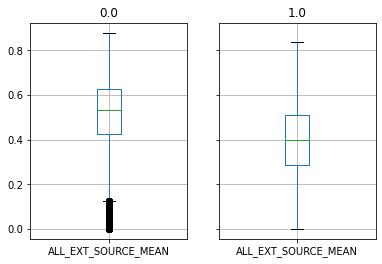

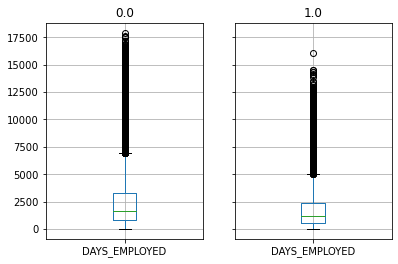

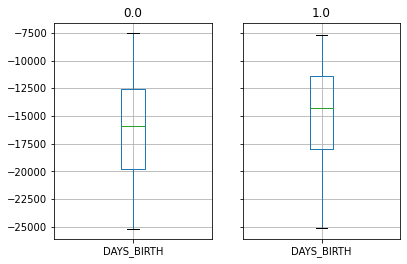

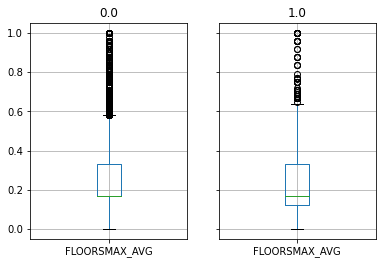

In [152]:
for column_tuple in sorted_biggest_distribution_features[:15]:
    column_name = column_tuple[0]
    if column_name in ['ALL_EXT_SOURCE_MEAN', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'FLOORSMAX_AVG']:
        axes = df[['TARGET', column_name]].groupby('TARGET').boxplot(column=column_name)
        fig = axes[0].get_figure()
    #fig.suptitle('test')

In [174]:
columns_to_keep = list(map(lambda x: x[0], filter(lambda x: x[1] > .3 or x[1] < .13, sorted_biggest_distribution_features))) + ['TARGET'] + categorical_columns 
print(columns_to_keep)
print(categorical_columns)
print(len(columns_to_keep))

sub_df = df[columns_to_keep]
sub_df.info()

['ALL_EXT_SOURCE_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'LIVINGAREA_MODE', 'APARTMENTS_AVG', 'MIS_INSTALMENT_PAYMENTS', 'AMT_CREDIT', 'APARTMENTS_MEDI', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_6', 'DEF_30_CNT_SOCIAL_CIRCLE', 'APARTMENTS_MODE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_WORK_PHONE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'FLAG_PHONE', 'YEARS_BUILD_MEDI', 'HOUR_APPR_PROCESS_START', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'BASEMENTAREA_MODE', 'FLAG_OWN_CAR', 'COMMONAREA_MEDI', 'COMMONAREA_AVG', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'ENTRANCES_MODE', 'CNT_CHILDREN', 'COMMONAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'FLAG_DOCUMENT_13', 'NONLIVINGAREA_MODE', 'ANNUITY_INCOME_IN_PERCENTAGE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_ANNUITY', 'PAYMENT_RATE', 'FLAG_DOCUMENT_16', 'DPD_COUNTS', 'LANDAREA_MEDI', 'LANDAREA_AVG', 'FLAG_DOCUMENT_14', 'LANDAREA_MODE', 'YE

In [175]:
# from sklearn import preprocessing

# si = SimpleImputer(strategy='median')
# new_df = si.fit_transform(df[numerical_columns])

# data_scaled = pd.DataFrame(preprocessing.scale(new_df), columns = numerical_columns) 

# pca = PCA()
# data_scaled
# pca.fit(data_scaled)

# ordered_by_variance = list(zip(data_scaled.columns, pca.explained_variance_))
# ordered_by_variance.sort(key = lambda x: x[1], reverse=True)

# columns_to_keep = list(map(lambda x: x[0], filter(lambda x: x[1] > .01, ordered_by_variance))) + ['TARGET'] + categorical_columns
# print(columns_to_keep)
# print(categorical_columns)
# print(len(columns_to_keep))

# sub_df = df[columns_to_keep]
# sub_df.info()

In [176]:
# def remove_high_correlated_columns(df, corr, threshold):
#     col_corr = set()
#     for i in range(len(corr.columns)):
#         for j in range(i):
#             if (corr.iloc[i, j] >= treshhold) and (corr.columns[j] not in col_corr):
#                 column_name = corr.columns[i]
#                 col_corr.add(column_name)
#                 if column_name in df.columns:
#                     print('REMOVING {} which is correlated with {}'.format(column_name, corr.columns[j]))
#                     del df[column_name]
#     return df

# print(len(df.columns))
# sub_df = remove_highly_correlated_columns(df, .8)
# display(len(sub_df.columns))

In [177]:
X, y = (sub_df.loc[sub_df['TARGET'].notnull(), :].drop(columns=['TARGET'], axis=1), 
        sub_df.loc[sub_df['TARGET'].notnull(), 'TARGET'])

# test set for kaggle
X_test = sub_df.loc[sub_df['TARGET'].isnull(), :].drop(columns=['TARGET'], axis=1)

# columns for pipeline
cat_cols = list(X.select_dtypes(include=object).columns)
num_cols = list(X.select_dtypes(include=[int, float]).columns)
len(cat_cols),len(num_cols)

(13, 57)

In [178]:
## pipelines

# one hot encoding 
categorical_pipe = Pipeline(steps=[
    ('cat_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
  ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# numerical 
numerical_pipe = Pipeline(steps=[
    ('num_imp', SimpleImputer(strategy='median', add_indicator=False)),
    ("scale", StandardScaler())  
])


# transform columns 
column_transformer = ColumnTransformer(transformers=[    
    ('num_pip', numerical_pipe, num_cols),
    ('cat_pipe', categorical_pipe, cat_cols)
])

In [179]:
# apply preprocessing to X
X_trans = column_transformer.fit_transform(X)

In [180]:
# smote sampling
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_trans,y)

# split data into k folds
# sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
# score_val = []
# for train_index, val_index in sss.split(X_sm, y_sm):
#     # initalize model 
#     model = LogisticRegression(solver='lbfgs', random_state=42,max_iter=1000)
#     # fit model 
#     model.fit(X_sm[train_index], y_sm[train_index])
#     # test model
#     score_val.append(balanced_accuracy_score(y_sm[val_index], model.predict(X_sm[val_index])))
## takes about 6 min to execute ... 2 min per fold 

In [181]:
X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state= 42, stratify=y_sm)
logreg= LogisticRegression(solver='lbfgs', random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)
y_pred_val = logreg.predict(X_val)
print('classifaction report on training set')
print(classification_report(y_train, y_pred_train, labels=[0,1]))
print('--------------------------------------------------------------')
print('classifaction report on validation set')
print(classification_report(y_val, y_pred_val, labels=[0,1]))

classifaction report on training set
              precision    recall  f1-score   support

           0       0.69      0.69      0.69    226145
           1       0.69      0.69      0.69    226146

    accuracy                           0.69    452291
   macro avg       0.69      0.69      0.69    452291
weighted avg       0.69      0.69      0.69    452291

--------------------------------------------------------------
classifaction report on validation set
              precision    recall  f1-score   support

           0       0.70      0.69      0.69     56537
           1       0.69      0.70      0.69     56536

    accuracy                           0.69    113073
   macro avg       0.69      0.69      0.69    113073
weighted avg       0.69      0.69      0.69    113073

